# TumorGrowth - methods

> This file demonstrates most functionality of the package.
Load Revise if you want to make changes to the source files.


In [1]:
using Pkg
Pkg.activate(pwd())
# Pkg.instantiate()
using Revise

@time using TumorGrowth

  Activating environment at `c:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\Project.toml`
┌ Info: Precompiling TumorGrowth [6c18b9fe-b06a-4315-99c1-34a00b453ec5]
└ @ Base loading.jl:1342


Loading Packages... Done!
 23.989624 seconds (23.98 M allocations: 1.569 GiB, 3.48% gc time, 1.64% compilation time)


## Sandbox

In [2]:
using Random
using LinearAlgebra
using Statistics
using DataFrames
using Plots

In [32]:
@time simoutput = birth_death_pushing(5000; b=1.0, d=0.8, mu=0.1, rho=1.6, dim=2, showprogress=true)
tumor = simoutput[:tumor]
mutations = simoutput[:mutations]

tumordf = tumor |> DataFrame
mutationsdf = mutations |> DataFrame
;

Progress: Tumor size  4986 	 Time: 0:00:24

 25.213597 seconds (25.56 M allocations: 9.704 GiB, 3.97% gc time, 0.56% compilation time)


In [33]:
ds = map( cell -> TumorGrowth.get_deathrate(cell, tumor), tumor);

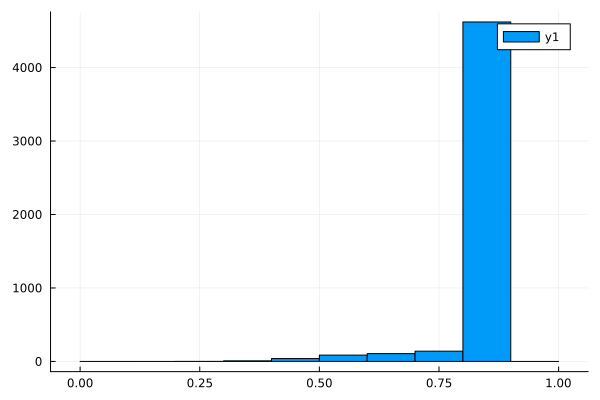

In [34]:
Plots.histogram(ds, bins=0:0.1:1)

In [36]:
plotting(tumordf; color=ds/minimum(ds), colormap=cgrad(:reds), shading=false) |> display

GLMakie.Screen(...)

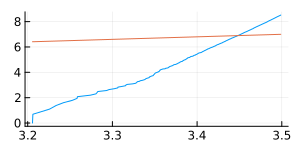

In [23]:
# power law / surface growth
Plots.plot(log.(tumordf.t_birth), log.(1:length(tumor)), legend=:none, size=(300, 150))
Plots.plot!(log.(tumordf.t_birth), t -> 2t)

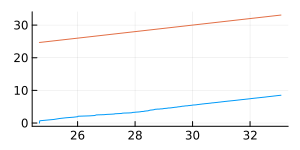

In [24]:
# exponential growth
Plots.plot((tumordf.t_birth), log.(1:length(tumor)), legend=:none, size=(300,150))
Plots.plot!((tumordf.t_birth), t -> t)

In [19]:
cm = mean(tumordf.position)
r_max = maximum(norm(p - cm) for p in tumordf.position)

89.97406627555276

In [20]:
rho = pi * 30^2 / count(norm.(tumordf.position) .< 30)
sqrt(rho * nrow(tumordf) / pi)

85.96023825918792

In [13]:
d(r; del, R, r0, d_c=1) = 1 / (r / del + r0 / del) + (d_c - 1 / (R / del + r0 / del))

d (generic function with 1 method)

In [38]:
d(r; del, R, d_c) = d_c / (1 + exp(-(R - del/2 - r)*10/del))

d (generic function with 1 method)

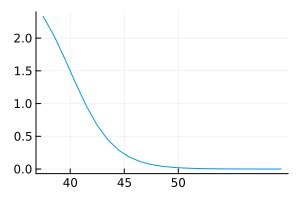

In [55]:
R  = 50
plot(R*3/4:R+10,
    r -> d(r; R=R, del = 20, d_c = 3),
    xticks=0:5:R, size=(300,200), lab=""
)

In [14]:
R = 50
del = R/4
r0 = R/5
R/del / (r0/del * (R/del+r0/del)) + 1

2.041666666666667

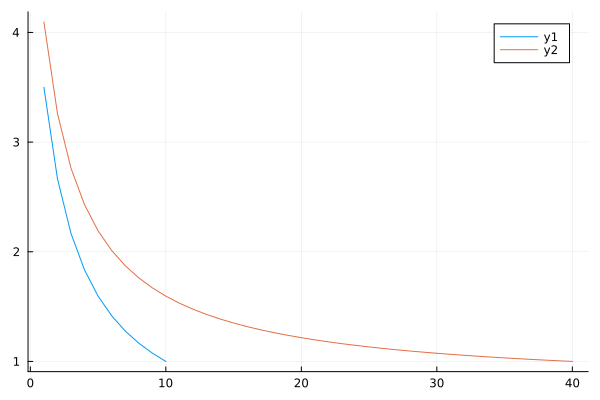

In [37]:
R = 10
plot(1:R,r
    r -> d(r; del=10, R=R, r0=2),
)
R=40
plot!(1:R,
    r -> d(r; del=10, R=R, r0=2),
)

In [6]:
cm  = mean(getfield.(tumor,:position))
R = maximum(norm(c.position-cm) for c in tumor)

ds = map(tumor) do cell
    TumorGrowth.get_deathrate(cell,tumor; del=R/1)
end

plotting(tumordf; color=ds, colormap=cgrad(:reds)) |> display

GLMakie.Screen(...)

## Simulation

In [5]:
@time simoutput = birth_death_pushing(3000; b=1.0, d=0.0, mu=0.1, rho=Inf, dim=2, seed=1010, showprogress=false)
tumor = simoutput[:tumor]
mutations = simoutput[:mutations]

tumordf = tumor |> DataFrame
mutationsdf = mutations |> DataFrame
;

 11.512020 seconds (23.13 M allocations: 4.770 GiB, 7.50% gc time, 12.54% compilation time)


In [6]:
@time simoutput = nonspatial(1000000; b=1., d=0.0, μ=0.3, showprogress=true)

Progress: Tumor size  980556 	 Time: 0:00:00

  0.949688 seconds (4.25 M allocations: 381.893 MiB, 17.85% gc time)


Dict{Symbol, Any} with 5 entries:
  :index     => 1000000
  :mutations => TumorGrowth.Mutation[Mutation(2, 0, 0.401391, 2, Float64[]), Mu…
  :mutation  => 299940
  :tumor     => TumorGrowth.Cell[Cell(1, Float64[], [10724], 0, 1.0, 0.0, Float…
  :time      => 14.2413

In [8]:
bumor = deepcopy(tumor)
butations = deepcopy(mutations)
birth_death_pushing!(bumor, butations, length(tumor)+1; 
    b=0.69, d=0.0, μ=0.3, dim=2,
    t=simoutput[:time], cur_id=simoutput[:index], cur_mutation=simoutput[:mutation])

Dict{Symbol, Any} with 3 entries:
  :index    => 1000001
  :mutation => 299940
  :time     => 14.2414

## Tumor saving

In [10]:
import CSV

In [11]:
tumor = birth_death_pushing(5000; b=1., d=0.0, μ=0.3, ρ=6., dim=3, seed=1234)[:tumor]
CSV.write("examples/test_5000_3d.csv", DataFrame(tumor), delim='\t')
b = data_import("examples/test_5000_3d.csv")

Progress: Tumor size  4933 	 Time: 0:00:02

,index,position,mutations,parent,b,t_birth,p_birth
,Int64,Array…,Array…,Int64,Float64,Float64,Array…
1,1,"[-0.582393, 2.49669, 8.72689]",[13],0,0.0,0.0,"[0.0, 0.0, 0.0]"
2,2,"[0.520122, 2.21109, -1.56466]",[1],1,0.0,0.690861,"[2.0754, -0.0430698, -0.317616]"
3,3,"[5.06704, 1.39896, 3.26483]",[12],2,0.0,1.38097,"[3.76022, 0.648446, 0.727929]"
4,4,"[2.52166, -7.11819, -3.39967]","[2, 83]",2,0.0,2.17964,"[0.884112, -1.44716, -1.32726]"
5,5,"[-3.9795, 0.889242, 3.50575]",[9],1,0.0,2.46947,"[-1.72863, 0.776218, 0.905174]"
6,6,"[4.07433, -1.14983, -5.57087]",[],3,0.0,2.93689,"[3.42061, 0.788683, -1.33968]"
7,7,"[1.59582, 3.4675, -4.50046]",[],6,0.0,3.47949,"[3.56256, 0.508106, -3.416]"
8,8,"[3.01806, 1.36804, 2.76495]","[1, 5, 19]",2,0.0,3.50446,"[2.49302, 0.564891, 1.70799]"
9,9,"[8.35515, -5.52964, -3.21055]",[17],6,0.0,3.80476,"[4.4815, -0.309531, -2.93806]"


## Time series

In [ ]:
N, simparams... = (N=5000, b=1., d=0.0, μ=0.3, ρ=6., dim=3, seed=1234)
tumor = birth_death_pushing(N; showprogress=false, simparams...)[:tumor] |> DataFrame

time_series = tumor_stepper(range(0.0, last(tumor.t_birth), length=50); simparams...)

last(time_series) == tumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


true

In [9]:
N, simparams... = (N=5000, b=1., d=0.0, mu=0.3, dim=2, seed=1234)
tumor = birth_death_pushing(N; showprogress=false, simparams...)[:tumor] |> DataFrame

time_series = tumor_stepper(range(0.0, last(tumor.t_birth), length=50); simparams...)

last(time_series) == tumor

true

In [10]:
using Plots: palette
record_growth(time_series; path="examples/temp.gif",
        frames=2, shading=false, show_axis=false,
        colorpalette = palette(:tab20)
        )

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


"examples/temp.gif"

## Plotting

In [12]:
using Plots: palette

b = data_import("examples/test_2000_2d.csv")
@time plotting(b)

  8.791915 seconds (26.00 M allocations: 1.370 GiB, 4.51% gc time, 98.39% compilation time)


In [13]:
@time plotting_colored_mutations(b, colorpalette = palette(:tab20), shading=false, inline=false, show_warning = true, path="examples/test_2000_2d.png")

  2.898281 seconds (8.88 M allocations: 560.543 MiB, 2.77% gc time, 95.80% compilation time)


┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


In [14]:
b = data_import("examples/test_5000_3d.csv")
@time plotting(b)

  1.409850 seconds (8.83 M allocations: 275.927 MiB, 90.93% compilation time)


In [15]:
@time plotting_colored_mutations(b, shading=true, path="examples/test_5000_3d.png", size=(500,500))

  0.354947 seconds (3.29 M allocations: 73.284 MiB, 24.45% compilation time)


┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


### *translating and layouts*

In [16]:
using GLMakie

In [17]:
tumor1 = birth_death_pushing(10000; b=1.,d=0., μ=0.2, ρ=7., dim=3)[:tumor] |> DataFrame
tumor2 = birth_death_pushing(10000; b=1.,d=0., μ=0.2, ρ=Inf, dim=3)[:tumor] |> DataFrame
tumor3 = birth_death_pushing(3000; b=1.,d=0., μ=0.2, ρ=1.4, dim=2)[:tumor] |> DataFrame

Progress: Tumor size  2995 	 Time: 0:00:01

,index,position,mutations,parent,b,t_birth,p_birth
,Int64,Array…,Array…,Int64,Float64,Float64,Array…
1,1,"[-4.99309, -0.210119]",[],0,0.0,0.0,"[0.0, 0.0]"
2,2,"[-4.00741, -2.24503]",[1],1,0.0,1.57901,"[-0.885364, -1.90424]"
3,3,"[8.62228, 4.74437]",[],1,0.0,3.63686,"[1.65175, 1.29681]"
4,4,"[-5.27558, 4.32129]",[],1,0.0,4.63986,"[-0.712605, 1.9754]"
5,5,"[0.460848, -2.33259]",[],2,0.0,5.55456,"[1.13115, -1.31801]"
6,6,"[3.07904, 0.976179]",[3],5,0.0,5.59782,"[0.675408, 0.731946]"
7,7,"[-9.02417, 1.39529]",[],5,0.0,6.03764,"[-0.429068, 0.0875972]"
8,8,"[-6.87356, 0.931727]",[4],2,0.0,6.093,"[-2.45618, -3.49453]"
9,9,"[-2.33587, -5.04031]","[1, 2]",2,0.0,6.35839,"[-1.49891, -4.17566]"


In [18]:
scene = Scene(resolution = (1000, 1000), show_axis=false)
t1 = plotting_colored_mutations!(scene, tumor1;
        shading=true, colorpalette=cgrad(:reds)[0.4:0.1:1.] )
t2 = plotting_colored_mutations!(scene, tumor2;
        shading=true, colorpalette=cgrad(:blues)[0.4:0.1:1.] )[end]
t3 = plotting_colored_mutations!(scene, tumor3;
        shading=false, colorpalette=cgrad(:greens)[0.2:0.1:1.] )[end]
translate!(t2, Vec3f0(100, 0, 0))
translate!(t3, Vec3f0(50, 100, 0))
scene |> display

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


GLMakie.Screen(...)

In [19]:
using GLMakie.MakieLayout

In [20]:
scene, layout = layoutscene(show_axis=false)
layout[1, 1:2]  = ax1 = LScene(scene, camera = cam2d!, resolution=(500,500))
layout[2, 1]  = ax2 = LScene(scene, camera = cam3d!, raw = false, show_axis=false, resolution=(500,500))
layout[2, 2] = ax3 = LScene(scene, camera = cam3d!, raw = false, show_axis=false, resolution=(500,500))

t1 = plotting_colored_mutations!(ax2, tumor1;
        shading=true, colorpalette=cgrad(:reds)[0.4:0.1:1.] )
t2 = plotting_colored_mutations!(ax3, tumor2;
        shading=true, colorpalette=cgrad(:blues)[0.4:0.1:1.] )
# b = deepcopy(tumor3); b.position ./= 1.8
t3 = plotting_colored_mutations!(ax1, tumor3; markersize=1.1,
        shading=false, colorpalette=cgrad(:greens)[0.2:0.1:1.] )

scene |> display

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


GLMakie.Screen(...)

### *plotting sampletumors*

In [22]:
@time tumor = birth_death_pushing(3000; b=1., d=0.0, μ=0.5, ρ=1.6, dim=2, showprogress=false)[:tumor] |> DataFrame
samples, sampletumor = multi_region_sequencing(tumor, n=50);

  2.327656 seconds (7.87 M allocations: 1.447 GiB, 9.64% gc time)


In [24]:
plotting_sampletumor_pies(sampletumor, first=30, colorpalette = TumorGrowth.distinguishable_colors(30))

In [25]:
plotting_sampletumor_pies(sampletumor, mutations = [1,10,55])

## Sampling

In [26]:
b = data_import("examples/test_2000_2d.csv");

In [27]:
fig = b |> plotting_colored_mutations
cross_section(b; x=10., width=3.) |> data -> plotting!(fig, data; color=:black)
cross_section(b; y=25., width=3.) |> data -> plotting!(fig, data; color=:black)
radial_sample(b; r=30., width=3.) |> data -> plotting!(fig, data; color=:black)

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


In [28]:
fig = b |> plotting_colored_mutations
bulk(b; pos=(25.,0.), box=(20,30)) |> data -> plotting!(fig, data; color=:black)
punch(b; pos=(-20,-20), r=10) |> data -> plotting!(fig, data; color=:black)

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


In [29]:
b = data_import("examples/test_5000_3d.csv")
scene = b |> plotting_colored_mutations
cross_section(b; x=10., width=3.) |> data -> plotting!(scene, data; shading=true, color=:black, path="examples/test_5000_3d.png")
cross_section(b; y=5., width=3.) |> data -> plotting!(scene, data; color=:black)

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


## Multi-region sampling

In [ ]:
using Makie: meshscatter, meshscatter!, save, Point
using Statistics, DataFrames, LinearAlgebra, StatsBase

In [ ]:
@time tumor = birth_death_pushing(5000; b=0.69, d=0.1, μ=0.3, ρ=1.8, dim=2, seed=1010)[:tumor] |> DataFrame

lattice, samples = multi_region_sampling(tumor; n=24, cells_per_sample=20)
length(lattice), mean(size.(samples, 1))

In [ ]:
scene = plotting_colored_mutations(tumor)
for sample in samples
        plotting!(scene, sample; color=:black)
end

sample_r = 2 * sqrt(20 / π)
r = norm(std(tumor.position)) / 2
cm = mean(tumor.position)
density = size(punch(tumor; pos=cm, r=r), 1) / (π * r^2)
R = sqrt(size(tumor, 1) / (π * density))
a = minimum(pairwise(norm ∘ -, lattice) + I * 100)

# scene = plotting_colored_mutations(tumor)
meshscatter!(scene, [Point{2}.(lattice)...], markersize=sample_r, scale_plot=false)
meshscatter!(scene, 0:0.2:360 .|> ϕ -> Point{2}((R-a/2) .* (cosd(ϕ), sind(ϕ)) .+ cm), markersize=1.0)
display(scene)

## Analysis

In [30]:
using Plots, StatsBase, Statistics

In [31]:
params = (b=1., d=0.2, μ=0.3, ρ=Inf, dim=3)
tumor = birth_death_pushing(4000; params...)[:tumor] |> DataFrame;

Progress: Tumor size  3994 	 Time: 0:00:03

,index,position,mutations,parent,b,t_birth
,Int64,Array…,Array…,Int64,Float64,Float64
1,4,"[-17.0279, -0.0944228, -3.1618]",[4],2,1.0,4.87684
2,10,"[-3.83604, 11.6934, -9.82333]",[5],9,1.0,6.95355
3,13,"[4.56276, 8.84815, 8.9415]","[7, 21]",9,1.0,7.63742
4,14,"[11.529, 10.2096, -2.84196]","[11, 984]",13,1.0,7.64333
5,16,"[9.56642, -14.8992, -1.81125]",[],15,1.0,7.87434
6,18,"[-6.63023, 17.424, 0.521025]",[843],14,1.0,7.98299
7,21,"[-2.66822, -13.0479, -5.78213]","[1, 119, 136]",2,1.0,8.02655
8,27,"[1.66569, -7.22833, 10.8225]",[347],13,1.0,8.22172
9,35,"[10.3418, 1.6289, -1.88615]",[111],27,1.0,8.65431


In [32]:
function M!(fig, f; res=0.0, nBins = 100, normalize=false, plotargs...)
        hist = fit(Histogram, 1 ./ f[res.<f], nbins=nBins, closed=:left)
        Mcounts = [ sum(hist.weights[1:n]) for n=1:length(hist.weights)]
        Mcounts = normalize ? Mcounts ./ last(Mcounts) : Mcounts
        Plots.plot!(fig, midpoints(hist.edges[1]), Mcounts; plotargs...)
end
M(f; res=0.0, nBins = 100, normalize=false, plotargs...) = M!(Plots.plot(), f; res=res, nBins = nBins, normalize=normalize, plotargs...)

M (generic function with 1 method)

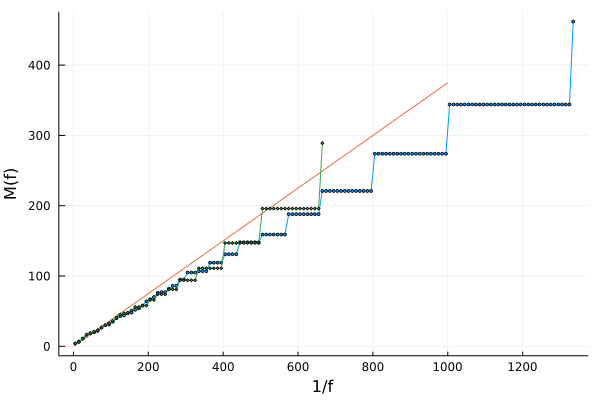

In [33]:
fig = M(mutation_freqs(tumor).frequency; res=0.0005, nBins=200,
        xlab="1/f", ylab="M(f)", lab="", marker=:o, ms=1.5)
β = params.μ * params.b/(params.b-params.d)
Plots.plot!(1:1000, n-> β*n, lab="")

f = filter(m -> m.reads > 1, stochastic_sequencing(tumor, readdepth=1000)).frequency
M!(fig, stochastic_sequencing(tumor, readdepth=2000).frequency; res=0.001, lab="", marker=:d, ms=1.5 )

### clones

In [40]:
tumor = data_import("examples/test_2000_2d.csv")

fig = plotting(tumor; color=:lightblue, shading=false)
clone(tumor, nothing) |> t -> plotting!(fig, t, color=:red)
clone(tumor, 2) |> t -> plotting!(fig, t, color=:blue)

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:100
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:100


In [47]:
fig = plotting(tumor; color=:lightgrey, shading=false)
sort(by=size, rev=true, clones(tumor))[1] |> clones .|> t -> plotting_colored_mutations!(fig, t; colorpalette=palette(:tab10), shading=false,autodepth=true)
fig

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth c:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115
┌ Warning: This method a

### *density ~ b*

In [1]:
using Plots, Statistics

# TumorGrowth.b_linear()
TumorGrowth.b_hill(6)
TumorGrowth.b_curve(1.; bup=1., ρc=1.1)

UndefVarError: UndefVarError: TumorGrowth not defined

In [37]:
b, d, ρ = 1., 0.2, 1.1
@time tumor = birth_death_pushing(5000; b=1., d=d
    , μ=0.3, ρ=ρ, dim=2, showprogress=false, seed=4242)[:tumor]
tumordf = tumor |> DataFrame;

  5.522627 seconds (13.86 M allocations: 2.408 GiB, 5.84% gc time, 2.65% compilation time)


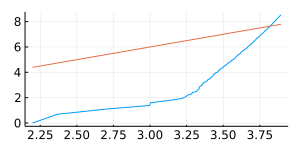

In [38]:
# power law / surface growth
Plots.plot(log.(tumordf.t_birth), log.(1:length(tumor)), legend=:none, size=(300,150))
Plots.plot!(log.(tumordf.t_birth), t -> 2*t)

In [1]:
Plots.histogram(tumordf.b, alpha=0.3, lw=0.2, lab="b")
Plots.vline!([median(tumordf.b)], lab="median", c=:blue)
Plots.vline!([d], lab="d", c=:black)

UndefVarError: UndefVarError: Plots not defined

In [ ]:
plotting(tumordf; color = tumordf.b./maximum(tumordf.b), colormap = cgrad(:reds))

### reduce mutation rate

In [ ]:
b, d, μ = 0.69, 0.1, 1.0
@time tumor = birth_death_pushing(5000; b=b, d=d, μ=μ, ρ=Inf, dim=2)[:tumor] |> DataFrame

In [ ]:
x = 0.3
tumor_reduced = reduced_μ(tumor, x)